# CNN 遥感图像分类项目

## 数据说明
This is a 21 class land use image dataset meant for research purposes. 
There are 100 images for each of the following classes:
+ agricultural
+ airplane
+ baseballdiamond
+ beach
+ buildings
+ chaparral
+ denseresidential
+ forest
+ freeway
+ golfcourse
+ harbor
+ intersection
+ mediumresidential
+ mobilehomepark
+ overpass
+ parkinglot
+ river
+ runway
+ sparseresidential
+ storagetanks
+ tenniscourt

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Download site: http://weegee.vision.ucmerced.edu/datasets/landuse.html

# 1. 读取原始数据和文件

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
import cv2

from PIL import Image
import os
from shutil import copyfile

In [ ]:
#!pip freeze 

In [ ]:
print(keras.__version__)

In [ ]:
category_names = [
    'agricultural',
    'forest',
    'mobilehomepark',
    'overpass',
    'parkinglot',
    'river',
    'runway',
    'sparseresidential'
]

In [ ]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [ ]:
# Load the numpy datasets
images_orig = np.load('data/UCMerced_images_orig_MultiClass.npy')
labels_num = np.load('data/UCMerced_labels_num_MultiClass.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.
labels = to_categorical(labels_num, nb_classes)

print('Orginal Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels_num[i])

print('One-hot encoded Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels[i])

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))

# 2. Split train, val and test

In [ ]:
nb_images = images_orig.shape[0]
nb_images

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [ ]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

Check how many images per class in train/val/test

In [ ]:
def unique_counts(arr):
    unique, counts = np.unique(arr, axis=0, return_counts=True)
    unique_num = [np.where(r==1)[0][0] for r in unique] 
    print(dict(zip(unique_num, counts)))

In [ ]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

# 3. Build CNN Base Model 

**Task**: Implement the following convolutional neural network (CNN). Consider the information in the Figure as well as the additional remarks:

* Use `strides = (1, 1)` for all convolutional layers. 
* Use `padding='same'` to pad the inputs and preserve the spatial dimensions after the convolution.
* Use 'relu' as activation for both conv and dense layers, except the last layer that should output 'softmax' or 'sigmoid' activations (pseudo class probabilities).
* The spatial extent is reduced by using max pooling with `pool_size = (3, 3)`. Set the parameter `strides`, such that the spatial extent is reduced by factor 2 in both spatial dimensions.
* Add a dropout layer with `prob_drop_hidden = 0.5` after the first dense layer.

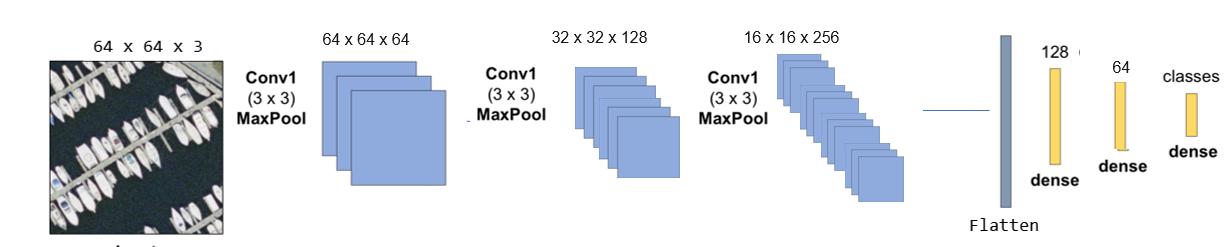

**Questions**:
1. What is the shape of a single filter kernel in the convolutional layer?
2. What is the shape of the output feature maps after the convolutional layer (before the MaxPooling)?
3. `model.summary()` shows the dimension of each layer output. What is the first dimension (None) of the output shape?

In [ ]:
# parameters:
input_shape = (int(patch_size/4), int(patch_size/4), channels)
pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

def define_CNN_base():

    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
    
    # conv2 layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

    # conv3 layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # fc2 layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (softmax)
    model.add(Dense(nb_classes, activation='softmax'))
    #model.add(Dense(nb_classes, activation='sigmoid'))

    return model

# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_base = define_CNN_base()
model_CNN_base.summary()

# 4. Train the base model

In [ ]:
# Set hyper parameters
epochs = 500
base_learning_rate=0.0001
batch_size = 32

In [ ]:
# Calculate the number of batches per epoch. 
# One epoch is defined as an update pass through the full training data. 
# One iteration is defined as an update through one mini-batch.
batches_per_epoch = y_train.shape[0]//batch_size
# the number of batches to see the full validation data:
validation_steps = y_val.shape[0]//batch_size
print('number of images per batch: {}'.format(batch_size))
print('batches per epoch: {}'.format(batches_per_epoch))
print('validation steps: {}'.format(validation_steps))

### Data augmentation

In [ ]:
# Data Generator provided by keras to load the training data in batches
image_gen = <YOUR_CODE_HERE>()

# At Test/Validation time without data augmentation
image_gen_test = <YOUR_CODE_HERE>()

In [ ]:
plt.figure(figsize=(12,12))
# configure batch size and retrieve one batch of images
for X_batch, y_batch in image_gen.<YOUR_CODE_HERE>(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	print('Total Images:', len(X_batch))
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(64, 64,3))
	# show the plot
	plt.show()
	break
    

In [ ]:
train_gen = image_gen.<YOUR_CODE_HERE>(np.array(X_train),
                           y_train,
                           batch_size = batch_size,
                           shuffle = True)
val_gen = image_gen_test.<YOUR_CODE_HERE>(np.array(X_val),
                              y_val,
                              batch_size = batch_size,
                              shuffle = True)


In [ ]:
# set your architecture
model = define_CNN_base()

Compile the model with loss and the Adam optimizer.

In [ ]:
# Define an optimizer
opt = Adam(lr=base_learning_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])    

In [ ]:
checkpoint_best_model = 'model/MultiClass_3Conv2Den_dataAugm.hdf5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=60)
mc = ModelCheckpoint(checkpoint_best_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Training commences by making a call to the fit method with our training and validation sets

In [ ]:
# Fit the model parameters
print('training...')

history = model.fit(
                x=<YOUR_CODE_HERE>,
                steps_per_epoch=batches_per_epoch, 
                epochs=epochs, 
                validation_data=<YOUR_CODE_HERE>,
                validation_steps=validation_steps,
                callbacks=[es, mc],
                verbose = 2,
                )

print('done')

In [ ]:
def history_plot(model_id, history):
	plt.figure(figsize=(8,10)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

In [ ]:
history_plot('CNN_base', history)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

In [ ]:
saved_model = load_model(checkpoint_best_model)

from datetime import datetime
DTime = datetime.now().strftime('%Y%m%d_%H%M%S')

_, acc = saved_model.evaluate(X_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

save_file = checkpoint_best_model[0:-5] +'_' + DTime + '_ACC' + str(acc_test)+'.h5'
print("Model saved: ", save_file)
saved_model.save(save_file,  save_format="h5")

# 5. Prediction on test image

In [ ]:
# load the weights form the best epoch
model = saved_model

print('predicting...')
predictions = model.predict(x=X_test, batch_size=batch_size)

# convert predictions    
print('num. predictions: ', len(predictions))

In [ ]:
y_pred = to_categorical(np.argmax(predictions, axis=1), nb_classes)

In [ ]:
# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

In [ ]:
# Confusion matrix
confmat = confusion_matrix( y_test.argmax(axis=1), predictions.argmax(axis=1))
confmat

In [ ]:
def plot_cm(y_true, y_pred, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d' % (c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d' % (c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})
    
    

In [ ]:
plot_cm( y_test.argmax(axis=1), predictions.argmax(axis=1))

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(nb_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - '+ category_names[i])
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# VISUALIZE IMAGES

import math

def plotImages_categories( images, labels, predictions, n_cols=4, figsize=(10, 10)):
    fig, axes = plt.subplots(math.ceil(len(images)/n_cols), n_cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(math.ceil(len(images)/n_cols) * n_cols):
        axes[i].set_xticks(())
        axes[i].set_yticks(())
        
        if i < len(images):
            axes[i].imshow(images[i])
            if predictions is not None:
                title = 'LABEL:{}\nPRED: {}'.format(labels[i], predictions[i])

                if predictions[i] != labels[i]:
                    [j.set_linewidth(5) for j in axes[i].spines.values()]
                    [j.set_color('red') for j in axes[i].spines.values()]

            else:
                title = 'LABEL:{}'.format(labels[i])
            axes[i].set_title(title, fontdict={'family':'monospace'}, loc='left',fontsize = 12)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(category_names)):
    cat = []
    cat_pred = []
    X_test_cat = []
    for j in range(len(y_test)):
        if y_test.argmax(axis=1)[j] == i:
            cat.append(category_names[i])
            cat_pred.append(category_names[predictions.argmax(axis=1)[j]])
            X_test_cat.append(X_test[j])
    
    print('\nCategory:{}, Total Samples:{}'.format(category_names[i], len(cat)))
    
    plotImages_categories(images=X_test_cat, labels=cat,
                          predictions=cat_pred, 
                        figsize=(12, 16))